In [1]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from numba import njit

# Reactions in stochastic particle models

Reactions are incorporated into stochastic transport models in many contexts. We will look at a few different variants, including a method called ''the Gillespie algorithm'', after the same Gillespie who wrote the paper we looked at in Exercise 7.

## Example 1: Exponential decay

Say we are considering the transport of a radioactive material, which decays with lifetime $\tau$. If we approximate the amount of radioactive material, $X$, as a continous variable (i.e., not a discrete number of atoms), the amount of remaining material is described by the ODE

$$ \dot{X} = -\frac{X}{\tau}, $$

which has the solution 

$$X(t) = X_0 \mathrm{e}^{-t/\tau},$$

where $X_0$ is the amount at $t=0$. We could also write down the equation for the amount of material that has decayed:

$$ D(t) = X_0 - X_0 \mathrm{e}^{-t/\tau} = X_0 \big(1 - \mathrm{e}^{-t/\tau}\big)$$

To implement this decay into our particle model, we will let the amount of radioactive material be represented by a (large) number of "numerical particles", and use the fact that for any individual particle, the probability of that particle decaying during an interval $\Delta t$ is $p = 1 - \mathrm{e}^{-\Delta t/\tau}$. For each particle, $i$, we draw a uniform random number, $r_i$ between 0 and 1, and if $r_i < p$, then we remove that particle from the simulation.

In [2]:
# An SDE solver
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

def run_experiment(X0, tmax, dt, a, b, tau, solver):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Np = len(X0)
    Nt = int(tmax/dt) + 1
    # Arrays to track solution
    X = np.zeros((Nt, len(X0)))
    X[0,:] = X0
    # value to flag removed particles
    flag = np.nan
    t = 0
    for n in trange(1, Nt):
        # Implement decay step
        p = 1 - np.exp(-dt/tau)
        r = np.random.random(size=Np)
        # Mark those particles where r < p as removed
        # (also keep removed those particles that have been previously removed)
        mask = (r < p) | np.isnan(X[n-1,:])
        X[n,mask] = np.nan
        # Call solver to make transport step, applying only to non-removed particles
        X[n,~mask] = solver(X[n-1,~mask], t, dt, a, b)
        t += dt
    return X

In [3]:
# Equation parameters
K0 = 0.1 # Diffusivity
tau = 1 # Decay liftetime

def a(X, t):
    return 0.0

def b(X, t):
    return np.sqrt(2*K0)

# Numerical parameters
Np = 100 # Number of particles
Tmax = 10 # Integration time
dt = 0.01 # Timestep

X0 = np.zeros(Np)
X = run_experiment(X0, Tmax, dt, a, b, tau, EM)
t = np.linspace(0, Tmax, X.shape[0])

# Convert X to masked array for convenience
X = np.ma.masked_array(X, mask=np.isnan(X))

  0%|          | 0/1000 [00:00<?, ?it/s]

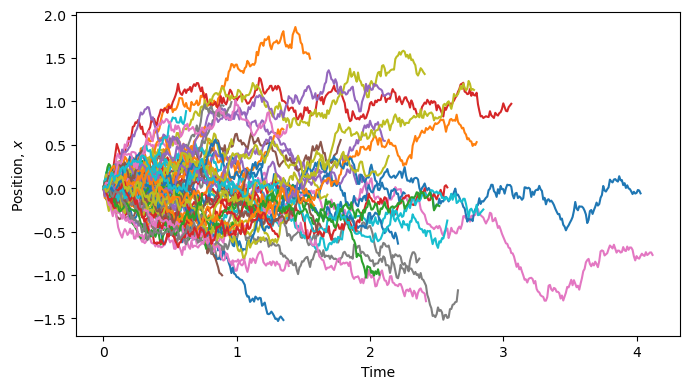

In [4]:
fig = plt.figure(figsize=(7, 4))
plt.plot(t, X)
plt.xlabel('Time')
plt.ylabel('Position, $x$')
plt.tight_layout()

In [5]:
# Equation parameters
K0 = 0.1 # Diffusivity
tau = 1 # Decay liftetime

def a(X, t):
    return 0.0

def b(X, t):
    return np.sqrt(2*K0)

# Numerical parameters
Np = 10 # Number of particles
Tmax = 10 # Integration time
dt = 0.01 # Timestep

X0 = np.zeros(Np)
X = run_experiment(X0, Tmax, dt, a, b, tau, EM)
t = np.linspace(0, Tmax, X.shape[0])

# Convert X to masked array for convenience
X = np.ma.masked_array(X, mask=np.isnan(X))

  0%|          | 0/1000 [00:00<?, ?it/s]

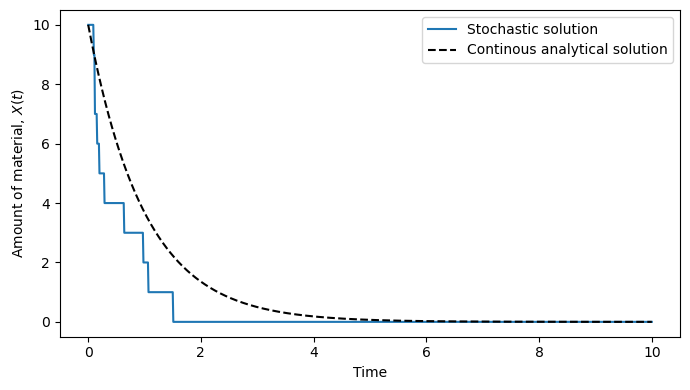

In [6]:
fig = plt.figure(figsize = (7,4))

plt.plot(t, np.sum(~X.mask, axis=1), label='Stochastic solution')
plt.plot(t, Np*np.exp(-t/tau), '--', c='k', label='Continous analytical solution')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Amount of material, $X(t)$')
plt.tight_layout()

## A note on the discretisation of the exponential decay reaction

Note that in the discretisation above, we used the analytical solution of exponential decay to calculate the probability of each particle decaying. In the case when the analytical solution is known, this is more accurate than using for example the Euler discretisation on the decay step as well.

With forward Euler, the numerical solution of exponential decay is:

$$X_{i+1} = X_i - X_i \frac{\Delta t}{\tau}, $$

which implies that the probability of decay is $\Delta t / \tau$. This is a first-order approximation of the analytical solution for $p$, as we can see by doing a series expansion of $\mathrm{e}^{-\Delta t/\tau}$:

$$p = 1 - \mathrm{e}^{-\Delta t/\tau} = \frac{\Delta t}{\tau} - \mathcal{O}(\Delta t^2).$$


The Euler approach requires $\Delta t \ll \tau$, and for cases where an analytical expression for $p$ is known, it is better to use that. 

## The Gillespie algorithm

The idea behind the Gillespie algorithm is that instead of taking a fixed timestep $\Delta t$, and checking if any reactions occurred, we instead use that the time between reactions is a random variable with an exponential distribution, and we draw a random time $t'$ to represent the time at which the next reaction occurs.

I believe this algorithm is most commonly used when we can assume that all the reactants are uniformly distributed throughout some volume, and we can thus ignore the transport part of the problem. Hence, we can represent the amount of reactant as an integer variable, instead of as an array of particles.

For a simple reaction where $X$ particles undergo exponential decay at a rate $k = 1/\tau$ (where $\tau$ is the lifetime, as before), we have that the time between reactions is exponentially distributed with mean $\frac{1}{Xk}$. We can draw numbers directly from this distribution with, for example, ```np.random.exponential```.

In [7]:
# Lifetime of decay
tau = 20
# Initial number of particles
X0 = 100
# Integration time
Tmax = 100

# Lists to store solutions
t = [0.0,]
X = [X0,]
# Loop over time
while t[-1] < Tmax:
    scale = tau/X[-1]
    dt = np.random.exponential(scale=scale)
    t.append(t[-1] + dt)
    X.append(X[-1] - 1)
    # If all particles are gone, stop the loop
    if X[-1] == 0:
        break

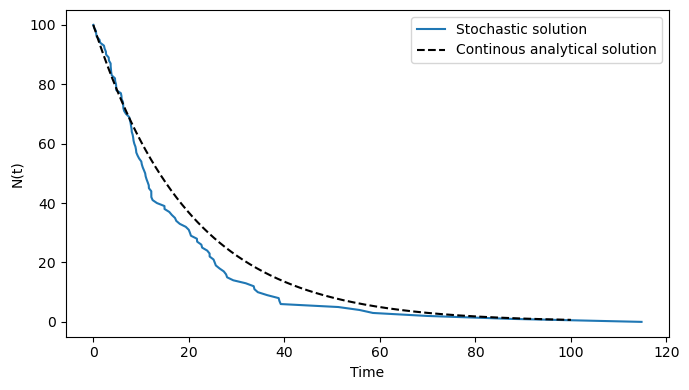

In [8]:
fig = plt.figure(figsize = (7,4))

plt.plot(t, X, label='Stochastic solution')

t_ = np.linspace(0, Tmax, 1000)
plt.plot(t_, X0*np.exp(-t_/tau), '--', c='k', label='Continous analytical solution')

plt.legend()
plt.xlabel('Time')
plt.ylabel('N(t)')
plt.tight_layout()

## Gillespie algorithm for multiple reactants and reaction pathways

The presentation here more or less follows Gillespie (2012).

Assume now that we have a system $N$ different types of molucules, and that the system is described by a vector $\mathbf{X}(t) = [X_1(t), ..., X_N(t)],$ where $X_i$ is the number of molecules of type $i$. We assume that these molecules are uniformly distributed throughout some volume, and that the volume remains constant. We only care about the reactions, not the positions of the reactants within the volume.

Next, assume that we consider $M$ possible chemical reactions, where each reaction involves either one or two molecules (which may be of the same or different types). For each type of reaction, $j$, we have a function $a_j(\mathbf{X}(t))$ called the propensity, which is defined such that

$$ a_j(\mathbf{X}(t)) \, \mathrm{d} t$$

is the probability that one reaction of type $j$ will happen during the infinitesimal interval $[t, t + \mathrm{d}t)$.

If a reaction $j$ is unimolecular, involving only a single molecule of type $i$, we can argue from fundamental chemical kinetics that there must exist a constant $c_j$, such that the probability of each of the $X_i$ molecules of type $i$ undergoing this reaction during the next interval of length $\mathrm{d}t$ is $c_j \, \mathrm{d}t$. The probability that (at least?) one of them reactions during the next interval of length $\mathrm{d}t$ is then

$$a_j\big( \mathbf{X}(t) \big) = X_i c_j \, \mathrm{d}t,$$

which we called the propensity function for reaction $j$.

(Note that this last step is based on the rules for addition of independent probabilities, and ignoring terms of order $\mathrm{d}t^2$ or higher, which is exact in the limit $\mathrm{d}t \to 0$.)

If instead reaction $j$ is bimolecular, involving two molecules of types $i$ and $i'$ (where we may have $i=i'$), then again we can argue from chemical kinetics that there exists a constant $c_j$ such that the probability of one of the pairs of molecules of types $i$ and $i'$ react in the next interval of length $\mathrm{d}t$ is $c_j \, \mathrm{d}t$. And again, considering the number of possible pairs of molecules of types $i$ and $i'$, we have that the propensity is

$$a_j\big( \mathbf{X}(t) \big) = X_i X_{i'} c_j \, \mathrm{d}t,$$

if $i\neq i'$, and

$$a_j\big( \mathbf{X}(t) \big) = \frac{1}{2} X_i (X_i - 1) c_j \, \mathrm{d}t,$$

if $i=i'$.

Finally, we introduce the vector $\mathbf{\nu}_j$, which describes the change in $\mathbf{X}$ due to one reaction of type $j$, such that if a reaction of type $j$ happens, then

$$ \mathbf{X} \to \mathbf{X} + \mathbf{\nu}_j. $$

### The Gillespie algorithm

We now define a new probability function

$$ p(\tau, j | \mathbf{X}, t) \mathrm{d}\tau $$

which is the joint probability distribution of the two random variables $\tau$, which is the time until the next reaction, and $j$, which is the type of the next reaction. One way to generate samples from this distribution is to draw two random, uniform numbers $r_1, r_2 \in [0, 1]$, and then calculate $\tau$ from

$$\tau = \frac{1}{a_0} \ln \left(\frac{1}{r_1}\right)$$

where $a_0(\mathbf{X}) = \sum_{j=1}^M a_j(\mathbf{X}(t))$, and let $j$ be the smallest integer that satisfies

$$ \sum_{j'=1}^j a_{j'}(\mathbf{X}) > r_2 a_0(\mathbf{X}).$$


To model a system with this approach, we can use the following recipe (Gillespie, 2012, p. 40):

First, initialise the system with a state vector $\mathbf{X}$, at time $t=0$. Then:
* For each $j=1,\ldots,M$, evaluate $a_j(\mathbf{X}(t))$, and calculate the sum $a_0$.
* Generate random values for $\tau$ and $j$, as shown above.
* Resolve the next reaction by setting $t \to t + \tau$ and $\mathbf{X} \to \mathbf{X} + \mathbf{\nu}_j$.
* Repeat these steps for as long as needed.


### The non-stochastic case

In the non-stochastic case, where the number of molecules are approximated as continuous variables, the ODE for the development of $\mathbf{X}$ is

$$\dot{\mathbf{X}} = \sum_{j=1}^{M} \nu_j a_j\big(\mathbf{X}(t)\big).$$

The argument for using the stochastic Gillespie algorithm is that in some cases, when the number of reactant molecules is small, the continuous version is not a good approximation. An example mentioned by Gillespie is the conditions in living cells, where some large molecules can be present in "small" numbers.

Below, we implement both methods and compare the results.

## Implementation of the Gillespie algorithm

Below, we implement the Gillespie algorithm for a system with three different molecules, and four different reactions.

In [9]:
# Rate coefficients
c1 = 1e-1
c2 = 1e-2
c3 = 2e-2
c4 = 2e-2

# Changes in X caused by reaction
nu = np.array([
    [-1, -1,  2,  0],
    [ 0, -1, -1,  2],
    [ 0,  1, -2,  1],
    [ 1,  1,  0, -2],
])

# Propensity functions
def a1(X):
    # This reaction is unimolecular:
    # 1 -> 2 + 3
    return c1*X[0]*X[1]

def a2(X):
    # This reaction is bimolecular:
    # 2 + 3 -> 1
    return c2*X[1]*X[2]

def a3(X):
    # This reaction is unimolecular:
    # 4 -> 3
    return c3*X[2]

def a4(X):
    # This reaction is bimolecular:
    # 2 + 4 > 1
    return c4*X[3]

In [10]:
X0 = np.array([1000, 0, 1000, 0])
Tmax = 300


t = [0,]
X = [X0,]
pbar = tqdm(total=Tmax)
while t[-1] < Tmax:
    # Evaluate the propensity functions
    a = np.array([a_(X[-1]) for a_ in [a1, a2, a3, a4]])
    a0 = np.sum(a)
    # Draw random numbers
    r1, r2 = np.random.random(size=2)
    # Calculate tau and j
    tau = np.log(1/r1) / a0
    j = np.argmax(np.cumsum(a) > r2*a0)
    # Apply nu_j and increment time
    X.append(X[-1] + nu[j])
    t.append(t[-1] + tau)
    pbar.update(tau)
    
t = np.array(t)
X = np.array(X)

  0%|          | 0/300 [00:00<?, ?it/s]

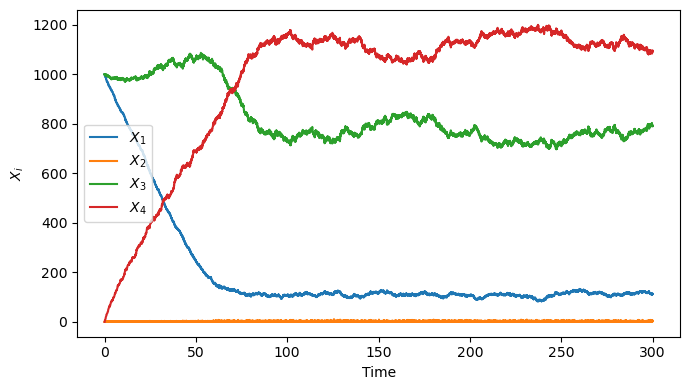

In [11]:
fig = plt.figure(figsize=(7,4))
for i in range(4):
    plt.plot(t, X[:,i], label=f'$X_{i+1}$')
    
plt.legend()
plt.xlabel('Time')
plt.ylabel('$X_i$')
plt.tight_layout()

## Non-stochastic implementation

Implementing the continuous variable version as a standard ODE, given by

$$ \dot{\mathbf{X}} = f(\mathbf{X}, t)$$

where 

$$f(\mathbf{X}, t) = \sum_{j=1}^{M} \nu_j a_j\big(\mathbf{X}(t)\big).$$

In [12]:
def f(X, t):
    a = np.array([a_(X) for a_ in [a1, a2, a3, a4]])
    return np.sum(nu * a[:,None], axis=0)

def rk4(X, t, dt, f):
    k1 = f(X,           t        )
    k2 = f(X + k1*dt/2, t + dt/2 )
    k3 = f(X + k2*dt/2, t + dt/2 )
    k4 = f(X + k3*dt,   t + dt   )
    return X + (k1 + 2*k2 + 2*k3 + k4) / 6

def solve_ODE(X0, Tmax, dt, f, solver):
    Nt = int(Tmax/dt) + 1
    X = np.zeros((Nt,4))
    X[0,:] = X0

    for i in trange(1, Nt):
        X[i,:] = X[i-1,:] + f(X[i-1,:], 0) * dt
        
    return X

In [13]:
dt = 0.001

X_ = solve_ODE(X0, Tmax, dt, f, rk4)
t_ = np.linspace(0, Tmax, X_.shape[0])

  0%|          | 0/300000 [00:00<?, ?it/s]

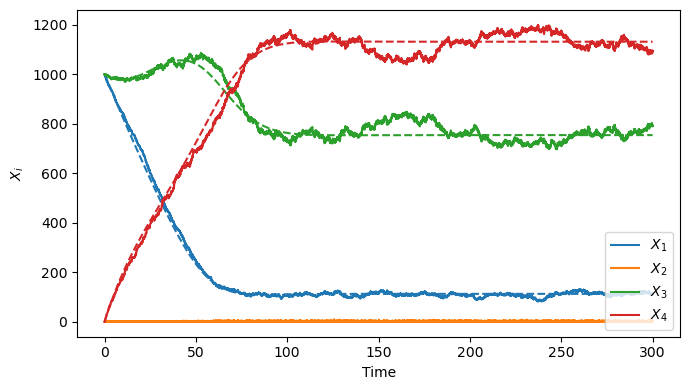

In [14]:
fig = plt.figure(figsize=(7,4))

for i in range(4):
    l, = plt.plot(t, X[:,i], label=f'$X_{i+1}$')
    plt.plot(t_, X_[:,i], '--', c=l.get_color())
    
plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('$X_i$')
plt.tight_layout()

## Smoluchowski coagulation equation

The coagulation equation describes how particles stick together to form larger particles. This process is also sometimes called aggregation or flocculation. Examples include formation of rain droplets or ice crystals in clouds, formation of mineral "flocs" in the ocean, or formation of planets from dust.

The equation exists in both continuous and discrete forms, depending on if the distribution of particle sizes is continuous or discrete. We will deal with the discrete case, and solve it with a stochastic particle model.

The discrete form of the equation reads

$$ \frac{\mathrm{d} n_i}{\mathrm{d} t} = \frac{1}{2} \sum_{j=1}^{i-1} K(m_i - m_j, m_j) \, n_i \, n_j - \sum_{j=1}^{\infty} K(m_i, m_j) \, n_i \,n_j, $$

where $n_i$ is the number of particles of mass $m_i$, and $K(m_i, m_j)$ is called the kernel. It represents the probability, per particle pair, that two particles of mass $m_i$ and $m_j$ collide and stick together to form a new, larger particle of mass $m_i + m_j$.

The two terms on the right-hand side of the equation represents first the rate at which particles of mass $m_i$ are created, and second the rate at which particles of mass $m_i$ are removed. Creation happens when two particles of masses $m_i - m_j$ and $m_j$ collide and stick together, since this will create a new particle with mass $m_i$. Removal happens when a particle of mass $m_i$ collides and reacts with any other particle, as this will create a new particle with mass larger than $m_i$.

### The kernel

The kernel, also called the collision kernel, depends on the context. For example in cloud physics, the kernel would take into account Brownian motion, vertical settling speeds and air turbulence, which makes the kernel a function of both particle mass (and size) and external factors that may change with time. 

For some special cases, such as the kernel being a constant, analytical solutions of the coagulation equation exist.

## Stochastic particle implementation

We will model the equation with an ensemble of particles, assumed to be uniformly distributed throughout some volume, and with a constant kernel. All particles start out with the same mass, $m$, which means that all aggregates consisting of $i$ primary particles will have a mass equal to $m_i = i \times m$.

With a constant kernel, $K$, the rate at which particles of masses $m_i$ and $m_j$ collide is $K \, n_i \, n_j$, which means that for each such pair of particles, the probability of a reaction happening during an interval $\Delta t$ is 

$$ p = 1 - \mathrm{e}^{-\Delta t K}. $$

We will implement this by considering all pairs of particles, and checking for a reaction by drawing a random number $r$, and letting the particles react if $r < p$ (Bernoulli trials). If two particles react, we remove one of them, and give the other particle a new mass equal to the sum of the two old masses.

In [15]:
@njit
def coagulate_dense(M, dt):
    # This function calculates coagulation for one timestep of duration dt
    # Inputs:
    # M  : An 1D array of masses.
    #    The length of this array is the original number of particles.
    #    Coagulation events reduce the number of particles.
    # dt : The duration of the timestep
    Np = len(M)
    K = 1e-5 # Constant collision kernel
    # Check all pairs of particles once
    for i in range(Np):
        # Only check for reactions if particle i is valid
        if M[i] > 0:
            for j in range(i-1): # Do not react with self
                # Check that particle j is also still valid
                if M[j] > 0:
                    # Probability of reacting
                    p = 1 - np.exp(-dt*K)
                    # Uniform random number
                    r = np.random.random()
                    # If reaction occurs, calculate new particle size
                    # Assign new size to one particle, and mark the other as removed
                    if r < p:
                        M[i] = M[i] + M[j]
                        M[j] = -999 # Using -999 to mark invalid particles
    return M

def experiment(M0, Tmax, dt):
    '''
    Run the model.

    M0:      Initial mass of particles (len(M0) = Np)
    Tmax:    Total duration of the simulation
    dt:      Timestep
    '''

    # Number of particles
    Np = len(M0)
    # Number of timesteps
    Nt = int(Tmax / dt) + 1
    # Array to store output
    M = np.zeros((Nt, Np))
    M[0,:] = M0.copy()
    
    # Time loop
    for i in trange(1, Nt):
        # Reaction
        M[i,:] = coagulate_dense(M[i-1,:].copy(), dt)

    return M

In [16]:
# Simulation time and timestep
Tmax = 50
dt = 0.5
# Number of particles 
Np = 50000
# Initial mass distribution, all particles have the same mass (m=1)
M0 = np.ones(Np)

# Run simulation
M = experiment(M0, Tmax, dt)

  0%|          | 0/100 [00:00<?, ?it/s]

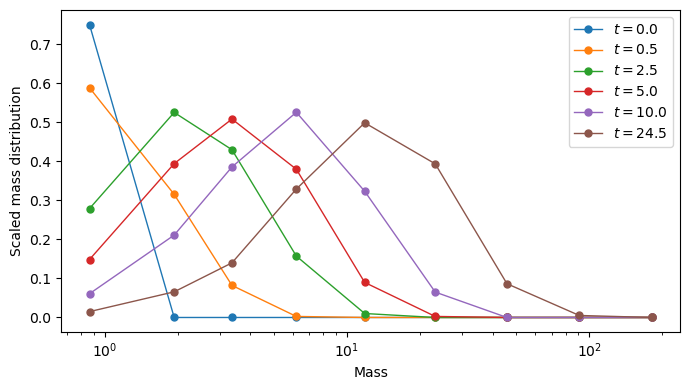

In [17]:
# Create logspaced bins
bins = np.array([0.5, 1.5, 2.5, 4.5, 8.5, 16.5, 32.5, 64.5, 128.5, 256.5])

# Find midpoints of the bins (on log scale)
mids = np.sqrt(bins[1:]*bins[:-1])

# Plot a few different timesteps
fig = plt.figure(figsize=(7, 4))
Nt = M.shape[0]
for it in [0, 1, 5, 10, 20, 49]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M[it,:][M[it,:]>0], bins=bins)
    # Plot particle counts times mass squared,
    # (see Figure is Wetherill)
    # and scaled by bin width and particle number
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')


plt.legend()
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Scaled mass distribution')
plt.tight_layout()

# Analytical solution for constant kernel

The function defined below combines Eqs. (6), (7) and (8) from Wetherill (1990), to give analytical solutions for the special case of constant kernel, and with the assumption that all particles start out with identical mass, $m$. This means that at all times, the mass of any particle will be $mk$, where $k = 1, 2, 3, ...$

https://www.sciencedirect.com/science/article/pii/001910359090086O

In [18]:
def nk(k, t, Np0, alpha=1e-5):
    # This function calculates the number of particles
    # with mass m*k at time t
    # Inputs:
    # k   : "Mass" (really the mass is m*k, but the m doesn't matter in this case)
    # t   : Time for which to calculate
    # Np0 : The initial number of particles (all of equal mass m)
    eta = alpha*Np0*t              # Eq. (7) in Wetherill, dimensionless time
    f = 1/(1 + eta/2)              # Eq. (6) in Wetherill
    return Np0*f**2 * (1-f)**(k-1) # Eq. (8) in Wetherill

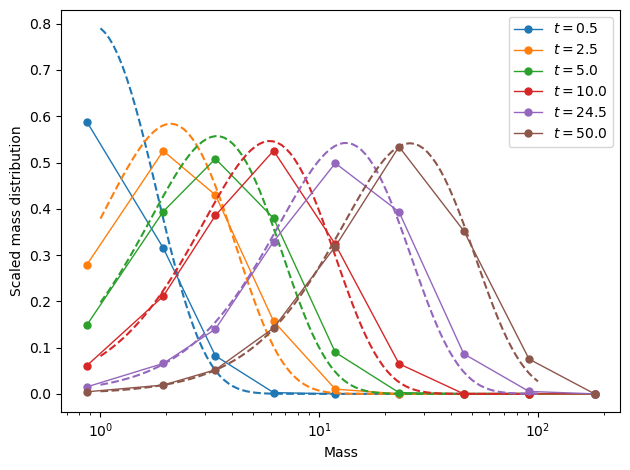

In [21]:
# array of masses for which to plot the analytical solution
ms = np.logspace(0, 2, 100)

# Plot a few different timesteps
Nt = M.shape[0]
for it in [1, 5, 10, 20, 49, 100]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M[it,:][M[it,:]>0], bins=bins)
    # Plot particle counts times mass squared,
    # (see Figure is Wetherill)
    # and scaled by bin width and particle number
    l, = plt.plot(mids, mids**2 * h / (Np * (bins[1:]-bins[:-1])), marker='.', lw=1, markersize=10, label=f'$t={it*dt}$')
    # Plot analytical solution for the same time (output timestep times time index)
    # and plotting for a larger number of masses, to get smooth curve
    plt.plot(ms, ms**2 * nk(ms, dt*it, Np) / Np, '--', c = l.get_color())


plt.legend()
plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Scaled mass distribution')
plt.tight_layout()